In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
from keras import backend as K
K.clear_session()

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import load_model

from keras import models
from keras import layers
from keras import optimizers

import matplotlib.pyplot as plt

## 1. Data Prep

In [4]:
#Data file locations
data_dir = 'D:\MSc2\Deep Learning Keras\Task8\Pokemon'
fnames = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir)]

In [5]:
len(fnames)

800

In [6]:
#Create the Data Matrix - 700 training images & 100 test images
data = np.empty([800,100,100,3], dtype=float) #(800, 100, 100, 3)
for i in range(0,len(fnames)-1):
    img_path = fnames[i]
    img = image.load_img(img_path, target_size=(100,100))
    x = image.img_to_array(img)
    data[i,:,:,:] = x

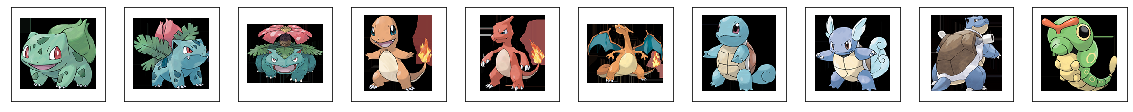

In [7]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    img_path = fnames[i]
    img = image.load_img(img_path, target_size=(100, 100))
       
    # display original
    ax = plt.subplot(1,10, i + 1)
    plt.imshow(img)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)   
plt.show()

In [8]:
#Normalize the data to [0,1] - Each pixel/channel has a value b/t [0,255]
data = data / 255.

In [9]:
data.mean(), data.std()

(0.6282403919934642, 0.42564578275583886)

In [10]:
#Train-Test split (700 vs 100)
x_train = data[:700,:,:,:]
x_test = data[700:,:,:,:]
x_train.shape, x_test.shape

((700, 100, 100, 3), (100, 100, 100, 3))

## 2. Shallow autoencoder - single dense layer

In [98]:
#Encoder = single fully-connected neural layer
#Decoder = single fully-connected neural layer

#The representations were only constrained by the size of the hidden layer (1024) - to have compact representations (bottleneck)
#The hidden layer is learning an approximation of PCA (note the activations are not linear functions)

In [11]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 128 # 128 floats -> compression of factor 30000/128 = 234, the input has 100*100*3 = 30,000 dimensions
                     #encoded dim of 1024
input_dim = 100*100*3

input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
autoencoder1 = Model(input_img, decoded)

In [12]:
#Configure the Autoencoder - per-pixel binary crossentropy loss, and the Adadelta optimizer
autoencoder1.compile(optimizer='adadelta', loss='binary_crossentropy') 
autoencoder1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3840128   
_________________________________________________________________
dense_2 (Dense)              (None, 30000)             3870000   
Total params: 7,710,128
Trainable params: 7,710,128
Non-trainable params: 0
_________________________________________________________________


In [13]:
#Flatten the input images - for MLP
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_train.shape, x_test.shape

((700, 30000), (100, 30000))

In [ ]:
#Train the Autoencoder 
##Note: Self-supervised learning, a specific instance of supervised learning where the targets
##are generated from the input data (here, y = x)
history1 = autoencoder1.fit(x_train, x_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test))

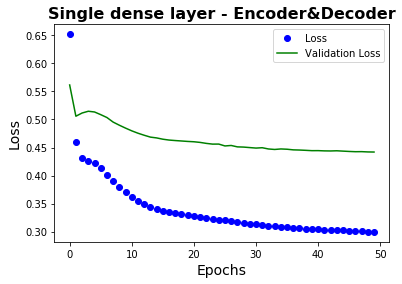

In [39]:
#Validation loss gets stable around 0.45
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Loss')
plt.plot(epochs, val_loss, 'g-', label='Validation Loss')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.title('Single dense layer - Encoder&Decoder', fontsize = 16, fontweight = 'bold')
plt.legend()

In [51]:
#Predictions from the model
predictions = autoencoder1.predict(x_test)

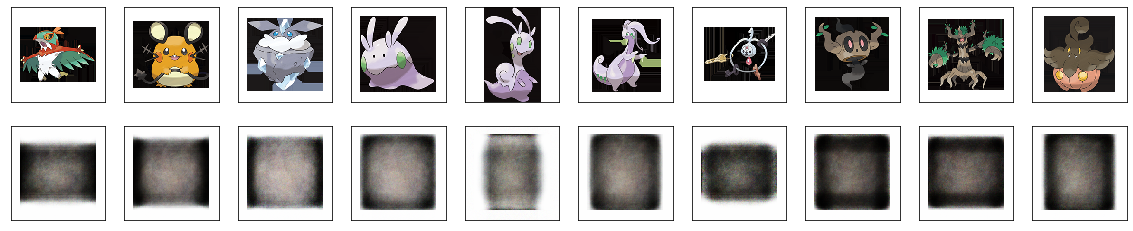

In [52]:
#Compare the original & reconstructed images 
n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(100,100,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i].reshape(100,100,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2. Deep Autoencoder 

In [44]:
input_img = Input(shape=(input_dim,))
encoded = Dense(512, activation='relu')(input_img)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dense(128, activation='relu')(encoded) #encoded to a latent space of dimension 128

decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(512, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder2 = Model(input_img, decoded)

In [45]:
autoencoder2.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 30000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 2048)              61442048  
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_12 (Dense)             (None, 2048)              2099200   
_________________________________________________________________
dense_13 (Dense)             (None, 30000)             61470000  
Total params: 128,159,024
Trainable params: 128,159,024
Non-trainable params: 0
______________________________________________________________

In [ ]:
history2 = autoencoder2.fit(x_train, x_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test))

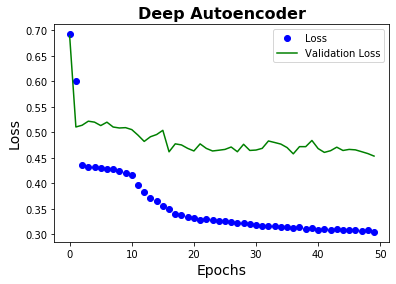

In [483]:
#Validation loss gets stable around 0.45
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Loss')
plt.plot(epochs, val_loss, 'g-', label='Validation Loss')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.title('Deep Autoencoder', fontsize = 16, fontweight = 'bold')
plt.legend()

In [484]:
#Predictions from the model
predictions = autoencoder2.predict(x_test)

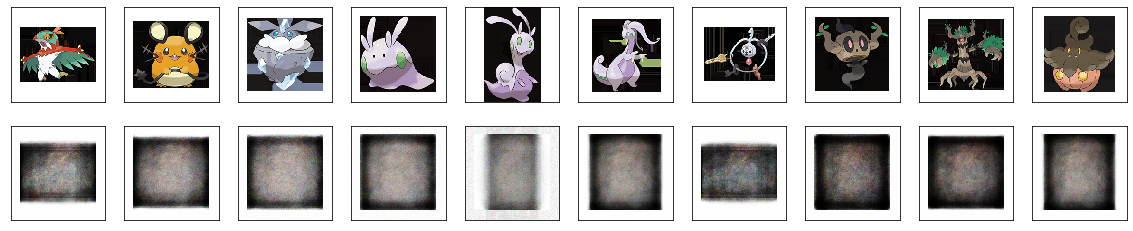

In [485]:
#Compare the original & reconstructed images
n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(100,100,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i].reshape(100,100,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 3. Convolutional Autoencoder

In [2]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model

Using TensorFlow backend.


In [ ]:
input_img = Input(shape=(100, 100, 3))  

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (25, 25, 64) - encoded dim = 40000 (very high entropic capacity)
#but even higher than the original image dim!! - not useful

x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder3 = Model(input_img, decoded)
autoencoder3.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder3.summary()

In [493]:
#For ConvNet - images of shape (100,100,3) instead of Flattened shape 30000
#Create the Data Matrix - 600 training images & 200 test images
data = np.empty([800,100,100,3], dtype=float) #(800, 100, 100, 3)
for i in range(0,len(fnames)-1):
    img_path = fnames[i]
    img = image.load_img(img_path, target_size=(100,100))
    x = image.img_to_array(img)
    data[i,:,:,:] = x
    
#Normalize the data to [0,1]
data = data / 255.
#data.mean(), data.std()

#Train-Test split (700 vs 100)
x_train = data[:700,:,:,:]
x_test = data[700:,:,:,:]
x_train.shape, x_test.shape

((700, 100, 100, 3), (100, 100, 100, 3))

In [69]:
#Another test set
x_test2 = data[300:400,:,:,:]

In [ ]:
#Similar results as the previous two
history3 = autoencoder3.fit(x_train, x_train, 
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test))

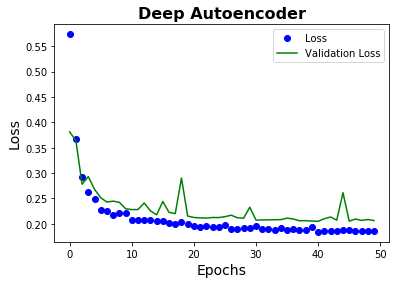

In [499]:
#Validation loss gets stable around 0.20 - significantly better
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Loss')
plt.plot(epochs, val_loss, 'g-', label='Validation Loss')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.title('Deep Autoencoder', fontsize = 16, fontweight = 'bold')
plt.legend()

In [70]:
#Predictions from the model
predictions = autoencoder3.predict(x_test)

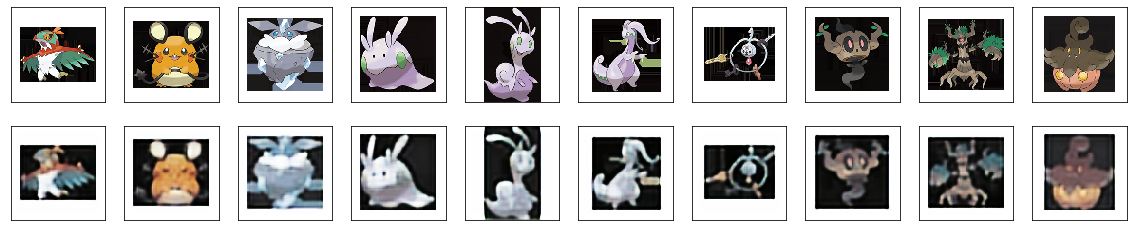

In [498]:
#Compare the original & reconstructed images
n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 4. Variational Autoencoder

In [500]:
##Roadmap
# Encode the input into a mean and variance parameter
#z_mean, z_log_variance = encoder(input_img)

# Draw a latent point using a small random epsilon
#z = z_mean + exp(z_log_variance) * epsilon

# Then decode z back to an image
#reconstructed_img = decoder(z)

# Instantiate a model
#model = Model(input_img, reconstructed_img)

# Then train the model using 2 losses:
# a reconstruction loss and a regularization loss

In [16]:
#For ConvNet - images of shape (100,100,3) instead of Flattened shape 30000
#Create the Data Matrix - 600 training images & 200 test images
data = np.empty([800,100,100,3], dtype=float) #(800, 100, 100, 3)
for i in range(0,len(fnames)-1):
    img_path = fnames[i]
    img = image.load_img(img_path, target_size=(100,100))
    x = image.img_to_array(img)
    data[i,:,:,:] = x
    
#Normalize the data to [0,1]
data = data / 255.
#data.mean(), data.std()

#Train-Test split (700 vs 100)
x_train = data[:700,:,:,:]
x_test = data[700:,:,:,:]
x_train.shape, x_test.shape

((700, 100, 100, 3), (100, 100, 100, 3))

In [17]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model

In [44]:
from keras.optimizers import RMSprop

In [93]:
#1. Encoder
img_shape = (100, 100, 3)
latent_dim = 2  # Dimensionality of the latent space: a plane
input_img = Input(shape=(100, 100, 3))  

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x) #(None, 50, 50, 64) - 160000 dims

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

z_mean = Dense(latent_dim)(x) #learning parameters
z_log_var = Dense(latent_dim)(x)

In [94]:
shape_before_flattening

(None, 50, 50, 64)

In [95]:
#2. Sampling from the latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.) #Standard Normal Distribution
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var]) #sampled points from the latent space

In [96]:
#3. Decoder
# This is the input where we will feed `z`.
decoder_input = Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(3, 3,
                  padding='same', activation='sigmoid')(x)
# We end up with a feature map of the same size as the original input.

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

In [98]:
#4. Loss function
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded) #Reconstruction loss - Binary CE b/t x and xhat
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) #Regularization loss - KL div b/t prior and latent
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])

In [102]:
vae = Model(input_img, y)
vae.compile(optimizer='adadelta', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 100, 100, 32) 896         input_18[0][0]                   
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 50, 50, 64)   18496       conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 50, 50, 64)   36928       conv2d_26[0][0]                  
__________________________________________________________________________________________________
conv2d_28 

In [ ]:
batch_size = 32
history = vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_data=(x_test, None))

In [ ]:
#Validation loss gets stable around 0.57
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Loss')
plt.plot(epochs, val_loss, 'g-', label='Validation Loss')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.title('Variational Autoencoder', fontsize = 16, fontweight = 'bold')
plt.legend()

In [80]:
##Visulize the generated images
##Scan the latent plane, sampling latent points at regular intervals, 
##and generating the corresponding image for each of these points (z -> x). 

##This gives us a visualization of the latent manifold that "generates" the images.

import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n1 = 5  #number of original images
n2 = 3 #number of times for morphing

# Linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n1)) #(n1,)
grid_y = norm.ppf(np.linspace(0.05, 0.95, n2)) #(n2,)

x_gen = np.empty([n1*n2,100,100,3], dtype=float) #(n1*n2, 100, 100, 3)
     
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        img = x_decoded[0] #(100,100,3) image
        x_gen[i,:,:,:] = img

In [ ]:
#Compare the original & reconstructed images
plt.figure(figsize=(n2*2, n1*2))

for i in range(n1*n2):    
    ax = plt.subplot(n1, n2, i + 1)
    plt.imshow(x_gen[i].reshape(100,100,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 5. Image Denoising using Convolutional Autoencoder

In [55]:
#For ConvNet - images of shape (100,100,3) instead of Flattened shape 30000
#Create the Data Matrix - 600 training images & 200 test images
data = np.empty([800,100,100,3], dtype=float) #(800, 100, 100, 3)
for i in range(0,len(fnames)-1):
    img_path = fnames[i]
    img = image.load_img(img_path, target_size=(100,100))
    x = image.img_to_array(img)
    data[i,:,:,:] = x
    
#Normalize the data to [0,1]
data = data / 255.
#data.mean(), data.std()

#Train-Test split (700 vs 100)
x_train = data[:700,:,:,:]
x_test = data[700:,:,:,:]
x_train.shape, x_test.shape

((700, 100, 100, 3), (100, 100, 100, 3))

In [97]:
#Create noisy images 
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

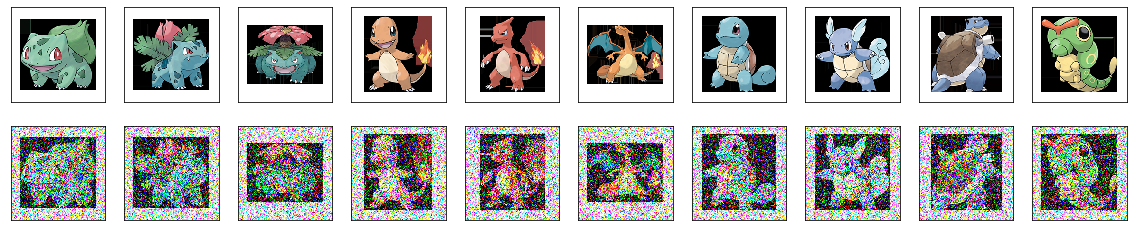

In [57]:
#Compare the original & noisy images
n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(100,100,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display noisy images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_train_noisy[i].reshape(100,100,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
input_img = Input(shape=(100, 100, 3))  

x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (25, 25, 128) - encoded dim = 80000 (very high entropic capacity)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder5 = Model(input_img, decoded)
autoencoder5.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder5.summary()

In [ ]:
history5 = autoencoder5.fit(x_train_noisy, x_train, #now different input and targets
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

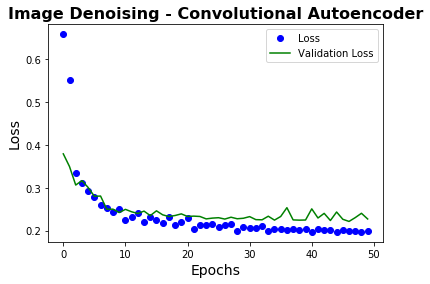

In [61]:
#Validation loss gets stable around 0.22
loss = history5.history['loss']
val_loss = history5.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Loss')
plt.plot(epochs, val_loss, 'g-', label='Validation Loss')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.title('Image Denoising - Convolutional Autoencoder', fontsize = 16, fontweight = 'bold')
plt.legend()

In [98]:
#Predictions from the model
predictions = autoencoder5.predict(x_test_noisy)

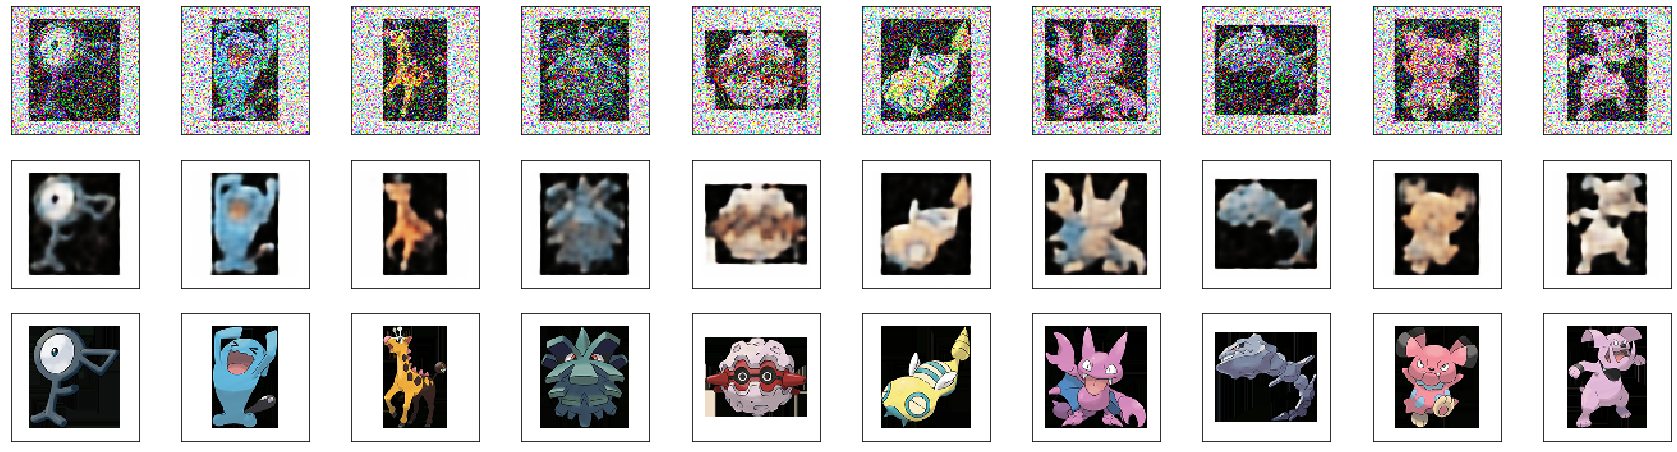

In [99]:
#Compare the noisy, reconstructed, and original images (noisy)
n = 10  
plt.figure(figsize=(30, 8))
for i in range(n):
    # display noisy
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(100,100,3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(predictions[i].reshape(100,100,3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #display original
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test[i].reshape(100,100,3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
plt.show()